In [1]:
from hyperEmbed import DynamicHypergraphDataset, DynamicHyperEmbed

In [5]:
config = {}
config["embedding_dim"] = 20
config["time_variance"] = 1.0
config["batch_size"] = 1000
config["epochs"] = 50
config["learning_rate"] = 0.1

In [3]:
%%time
dataset = DynamicHypergraphDataset("./data/medline")

  0%|          | 0/62 [00:00<?, ?it/s]

CPU times: user 41.4 s, sys: 3.78 s, total: 45.2 s
Wall time: 43 s


In [4]:
hyper_embed = DynamicHyperEmbed(
    num_nodes=dataset.num_nodes, embedding_dim=config["embedding_dim"], 
    time_keys=dataset.time_keys, time_variance=config["time_variance"])

In [ ]:
hyper_embed.train(
    dataset = dataset,
    num_epochs = config["epochs"],
    batch_size = config["batch_size"],
    shuffle = True,
    lr = config["learning_rate"])

In [ ]:
hyper_embed.save("saved_models/2023-03-24/")

In [1]:
from hyperEmbed import DynamicHypergraphDataset, DynamicHyperEmbed

In [2]:
%%time
dataset = DynamicHypergraphDataset("./data/medline", aggregate=False)

  0%|          | 0/62 [00:00<?, ?it/s]

CPU times: user 37 s, sys: 3.88 s, total: 40.9 s
Wall time: 38.5 s


In [6]:
import torch

model_config = torch.load("saved_models/2023-03-24/model_config.pkl")

hyper_embed = DynamicHyperEmbed(
    num_nodes=model_config["num_nodes"], embedding_dim=model_config["embedding_dim"], 
    time_keys=model_config["time_keys"], time_variance=model_config["time_variance"])

hyper_embed.load("saved_models/2023-03-24/")

In [15]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(
    dataset.hypergraphs[1991],
    batch_size=100,
    shuffle=False,
    collate_fn=dataset.hypergraphs[1991].get_collate_fn(label_tensor=False),
)

In [23]:
import torch
from tqdm.auto import tqdm

novelties = []
pmids = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        novelties.extend(hyper_embed.models[1990].get_novelty(batch[0], batch[2]).tolist())
        pmids.extend(batch[1])

  0%|          | 0/2971 [00:00<?, ?it/s]

In [26]:
%%time
import pickle
citations=pickle.load(open('../Hypergraph Novelty/Data/citations.pkl','rb'),encoding='latin1').tocsr()

<timed exec>:2: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.


CPU times: user 11.2 s, sys: 7.62 s, total: 18.8 s
Wall time: 20.5 s


In [33]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "pmid": pd.to_numeric(pmids), "novelty": novelties
})

c=citations[df["pmid"],:].sum(axis=1).A.ravel()
df['cites']=c
df['hit']=c>np.percentile(c,90)

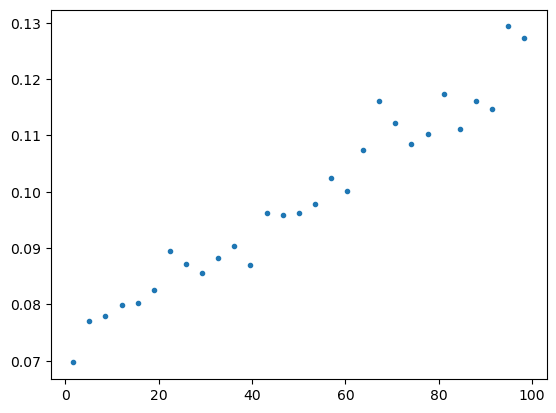

In [45]:
import matplotlib.pyplot as plt

percentitles=np.linspace(0,100,30)
x=-np.log(df.novelty)
xbins,indx=np.unique(np.percentile(x, percentitles), return_index=True)
H,_=np.histogram(x,xbins)
H2,_=np.histogram(x[df.hit],xbins)
y=H2/H
plt.plot( (percentitles[indx[1:]]+percentitles[indx[:-1]])/2 ,y, '.');